In [1]:
!pip install tensorflow==2.10.0
!pip install torch==1.12.1
!pip install transformers==4.20.1


In [2]:
import pandas as pd

# Reading the csv file
df = pd.read_csv('RansomwareData.csv')


In [3]:
X = df.drop([df.columns[0], df.columns[1], df.columns[2]], axis=1).values
y = df[df.columns[2]]

y_binary = df[df.columns[1]].values

# Create group labels
def convert_to_group(label):
    if 1 <= label <= 3:
        return 1
    elif 4 <= label <= 6:
        return 2
    elif 7 <= label <= 9:
        return 3
    elif 10 <= label <= 12:
        return 4
    else:
        return 0  # Assuming 0 is for goodware

y_group = y.apply(convert_to_group).values
y_specific = df[df.columns[2]].values

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, y_train_binary, y_test_binary, y_train_group, y_test_group = train_test_split(X, y, y_binary, y_group, test_size=0.2, random_state=42)

In [5]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the autoencoder with a larger encoding dimension
input_dim = X_train.shape[1]
encoding_dim = 256  # Increased dimension

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)

# Decoder
decoder = Dense(input_dim, activation="sigmoid")(encoder)

# Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder with a lower learning rate
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test))

Epoch 1/50
39/39 [==============================] - 17s 410ms/step - loss: 0.0844 - val_loss: 0.0067
Epoch 2/50
39/39 [==============================] - 14s 359ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 3/50
39/39 [==============================] - 7s 168ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 4/50
39/39 [==============================] - 9s 232ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 5/50
39/39 [==============================] - 7s 169ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 6/50
39/39 [==============================] - 9s 220ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 7/50
39/39 [==============================] - 9s 242ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 8/50
39/39 [==============================] - 14s 365ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 9/50
39/39 [==============================] - 9s 224ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 10/50
39/39 [==============================] - 7s 167ms/step - loss: 0.0023 - val_loss: 0.0

In [6]:
# Extract the encoder part of the autoencoder
encoder_model = Model(inputs=input_layer, outputs=encoder)

# Transform the data to encoded representations
X_train_encoded = encoder_model.predict(X_train)
X_test_encoded = encoder_model.predict(X_test)


10/10 [==============================] - 0s 22ms/step


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add
from tensorflow.keras.models import Model

# Define a simplified transformer block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define the simplified model
def create_simplified_model(input_shape):
    inputs = Input(shape=input_shape)
    dense_reduced = Dense(64, activation="relu")(inputs)
    dense_reduced = tf.expand_dims(dense_reduced, axis=1)  # Add sequence dimension

    transformer_block = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=64)
    x = transformer_block(dense_reduced)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)  # Pooling to reduce sequence dimension
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)

    # Classification heads
    binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
    group_output = Dense(5, activation='softmax', name='group_output')(x)
    specific_output = Dense(12, activation='softmax', name='specific_output')(x)

    model = Model(inputs=inputs, outputs=[binary_output, group_output, specific_output])
    return model

# Create and compile the model
model = create_simplified_model((256,))
model.compile(optimizer='adam',
              loss={'binary_output': 'binary_crossentropy', 'group_output': 'sparse_categorical_crossentropy', 'specific_output': 'sparse_categorical_crossentropy'},
              metrics={'binary_output': 'accuracy', 'group_output': 'accuracy', 'specific_output': 'accuracy'})

# Print the model summary
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 64)           16448       ['input_4[0][0]']                
                                                                                                  
 tf.expand_dims_2 (TFOpLambda)  (None, 1, 64)        0           ['dense_10[0][0]']               
                                                                                                  
 transformer_block_2 (Transform  (None, 1, 64)       74944       ['tf.expand_dims_2[0][0]']       
 erBlock)                                                                                   

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_encoded,
                    {'binary_output': y_train_binary, 'group_output': y_train_group, 'specific_output': y_train},
                    epochs=500,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])


Epoch 1/500
31/31 [==============================] - 3s 27ms/step - loss: 3.2280 - binary_output_loss: 0.5718 - group_output_loss: 1.1023 - specific_output_loss: 1.5539 - binary_output_accuracy: 0.6910 - group_output_accuracy: 0.5903 - specific_output_accuracy: 0.5791 - val_loss: 2.5019 - val_binary_output_loss: 0.4318 - val_group_output_loss: 0.8557 - val_specific_output_loss: 1.2144 - val_binary_output_accuracy: 0.8238 - val_group_output_accuracy: 0.6721 - val_specific_output_accuracy: 0.6680
Epoch 2/500
31/31 [==============================] - 0s 10ms/step - loss: 2.3091 - binary_output_loss: 0.3527 - group_output_loss: 0.7974 - specific_output_loss: 1.1590 - binary_output_accuracy: 0.8439 - group_output_accuracy: 0.6869 - specific_output_accuracy: 0.6407 - val_loss: 2.5321 - val_binary_output_loss: 0.4004 - val_group_output_loss: 0.8789 - val_specific_output_loss: 1.2527 - val_binary_output_accuracy: 0.8279 - val_group_output_accuracy: 0.6721 - val_specific_output_accuracy: 0.5861


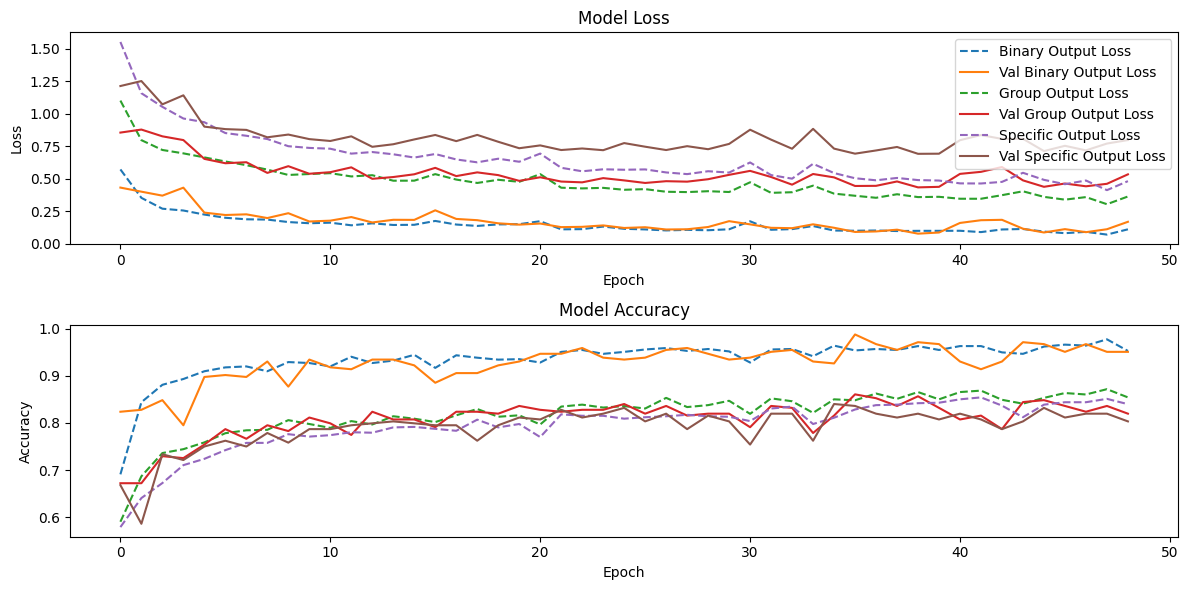

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(history.history['binary_output_loss'], linestyle='--', label='Binary Output Loss')
plt.plot(history.history['val_binary_output_loss'], label='Val Binary Output Loss')
plt.plot(history.history['group_output_loss'], linestyle='--', label='Group Output Loss')
plt.plot(history.history['val_group_output_loss'], label='Val Group Output Loss')
plt.plot(history.history['specific_output_loss'], linestyle='--', label='Specific Output Loss')
plt.plot(history.history['val_specific_output_loss'], label='Val Specific Output Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(2, 1, 2)
plt.plot(history.history['binary_output_accuracy'], linestyle='--', label='Binary Output Accuracy')
plt.plot(history.history['val_binary_output_accuracy'], label='Val Binary Output Accuracy')
plt.plot(history.history['group_output_accuracy'], linestyle='--', label='Group Output Accuracy')
plt.plot(history.history['val_group_output_accuracy'], label='Val Group Output Accuracy')
plt.plot(history.history['specific_output_accuracy'], linestyle='--', label='Specific Output Accuracy')
plt.plot(history.history['val_specific_output_accuracy'], label='Val Specific Output Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()


10/10 [==============================] - 0s 5ms/step


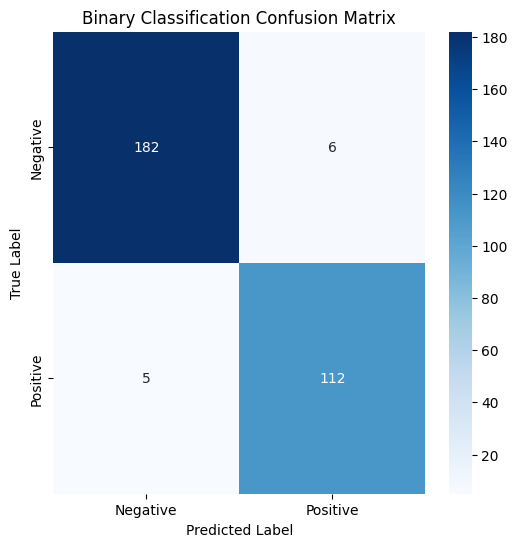

10/10 [==============================] - 0s 5ms/step


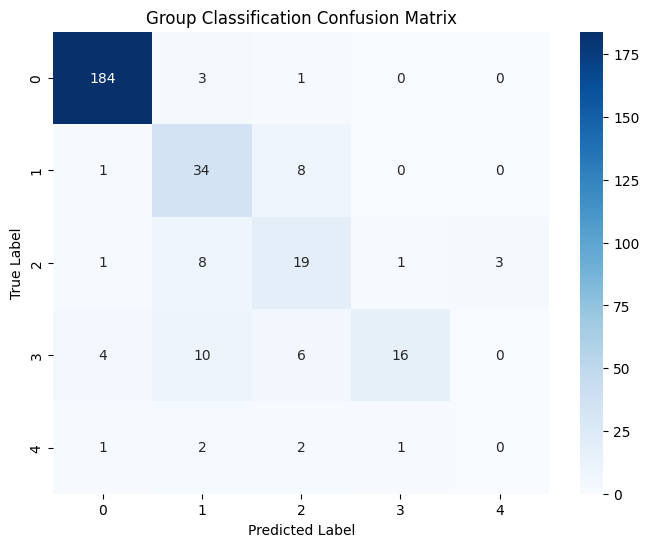

10/10 [==============================] - 0s 3ms/step


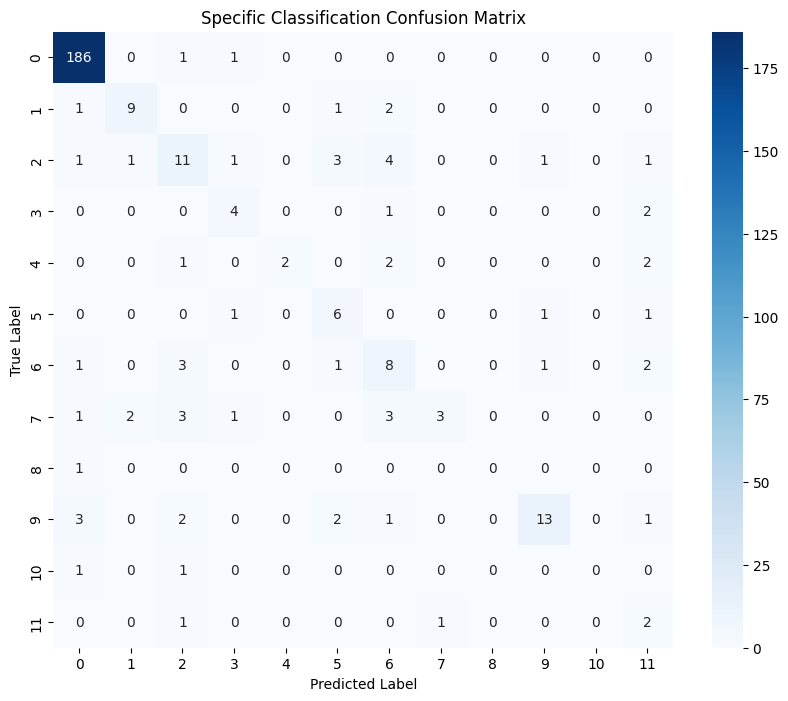

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


# Get predictions for binary classification head
y_binary_pred = model.predict(X_test_encoded)[0]
y_binary_pred_classes = (y_binary_pred > 0.5).astype("int32")


cm_binary = confusion_matrix(y_test_binary, y_binary_pred_classes)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sns.heatmap(cm_binary, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Binary Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Get predictions for group classification head
y_group_pred = model.predict(X_test_encoded)[1]
y_group_pred_classes = y_group_pred.argmax(axis=1)

# Compute confusion matrix
cm_group = confusion_matrix(y_test_group, y_group_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_group, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.title('Group Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Get predictions for specific classification head
y_specific_pred = model.predict(X_test_encoded)[2]
y_specific_pred_classes = y_specific_pred.argmax(axis=1)

# Compute confusion matrix
cm_specific = confusion_matrix(y_test, y_specific_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_specific, annot=True, fmt="d", cmap="Blues", xticklabels=range(12), yticklabels=range(12))
plt.title('Specific Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
